## Domain Adaptation SVM (Code) [10pts]

In [1]:
import pandas as pd
import numpy as np
# import cvxpy as cp
from cvxopt import solvers, matrix
import matplotlib.pyplot as plt

Read source and target data.

In [260]:
source_df = pd.read_csv('source_train.csv', header=None)
source_df.head()

,0,1,2
0,-1.72240,-0.47413,-1
1,-0.58501,-0.99149,-1
2,0.15012,-0.26945,-1
3,2.28760,0.15707,1
4,-1.12920,-0.89269,-1


In [10]:
target_df = pd.read_csv('target_train.csv', header=None)
target_df.head()

,0,1,2
0,1.11020,1.316500,1
1,0.12895,-0.107710,-1
2,1.43860,2.390000,1
3,-1.36110,-0.078012,-1
4,-1.67970,-0.335800,-1


Visualize data.

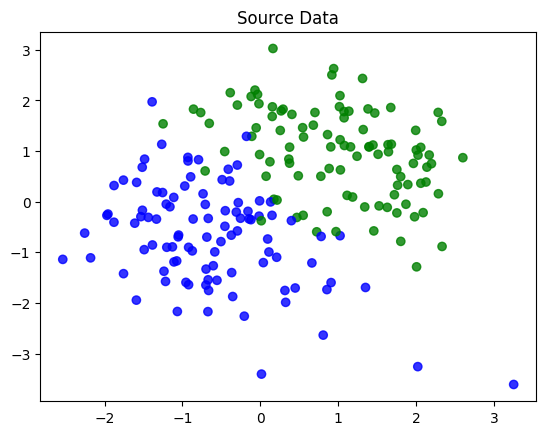

In [221]:
# plot source data
plt.scatter(source_df.iloc[:, 0], source_df.iloc[:, 1], c=source_df.iloc[:, 2].map({-1:'blue', 1:'green'}).astype(str), alpha=0.8)

plt.title('Source Data')
plt.show()

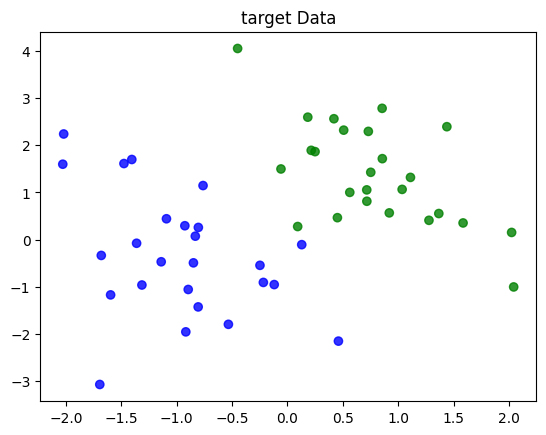

In [222]:
# plot target data
plt.scatter(target_df.iloc[:, 0], target_df.iloc[:, 1], c=target_df.iloc[:, 2].map({-1:'blue', 1:'green'}).astype(str), alpha=0.8)

plt.title('target Data')
plt.show()

Split data into covariates X and target y

In [264]:
# split source, target into X and y
target_X = target_df.iloc[:, :2].to_numpy()
source_X = source_df.iloc[:, :2].to_numpy()

target_y = target_df.iloc[:, 2].to_numpy()
source_y = source_df.iloc[:, 2].to_numpy()

Solve the QP problem. The dual form of the Soft Margin SVM is given by:

$$
\argmax_{\alpha} \sum_{i=1}^n \alpha_i - \frac{1}{2} \sum_{i=1}^n \sum_{j=1}^n \alpha_i \alpha_j y_i y_j \boldsymbol{x_i}^T \boldsymbol{x_j} 
\;\; \text{s.t.} \;\; \sum_{i=1}^n y_i \alpha_i = 0, \;\; 0 \leq \alpha_i \leq C
$$

In [519]:
def soft_SVM(X, y, C):
    """
    X: (ndarray) data
    y: (ndarray) target
    C: (float) SVM hyperparameter
    """
    # get number of instances
    n = X.shape[0]
    
    P = matrix(y @ y.T * X @ X.T)
    q = matrix(np.ones(n).astype(float))

    # G and h for inequality constraints
    g1 = np.asarray(np.diag(np.ones(n) * -1))
    g2 = np.asarray(np.diag(np.ones(n)))
    G = matrix(np.append(g1, g2, axis=0))
    G = matrix(G)
    h = matrix(np.append(np.zeros(n), (np.ones(n) * C), axis =0))

    # A and b for equality constraints
    A = matrix(y.astype(float).reshape(1, n))
    b = matrix([0.])

    return solvers.qp(P, q, G, h, A, b)

# solve SVM for source dataset
results = soft_SVM(source_X, source_y, C=10)

     pcost       dcost       gap    pres   dres
 0:  8.1843e+02 -7.9323e+03  9e+03  1e-13  2e-11
 1:  6.7633e+02 -5.6596e+02  1e+03  9e-14  1e-11
 2:  8.3174e+01 -2.6204e+02  3e+02  8e-14  1e-11
 3:  2.2743e+00 -3.2560e+00  6e+00  9e-16  1e-12
 4:  3.3065e-02 -4.8110e-02  8e-02  2e-16  3e-14
 5:  3.9402e-03 -5.7157e-03  1e-02  2e-16  3e-15
 6:  2.0288e-04 -1.3806e-04  3e-04  2e-16  6e-16
 7:  2.1618e-06 -1.4031e-06  4e-06  2e-16  7e-16
 8:  2.1617e-08 -1.4030e-08  4e-08  2e-16  6e-16
Optimal solution found.


Get the optimal hyperplane using

$$
\boldsymbol{W} = \sum_{i=1}^n \alpha_i y_i \boldsymbol{x}_i
$$

Soft Margin SVM (C=0.1) Training Accuracy: 93.5%


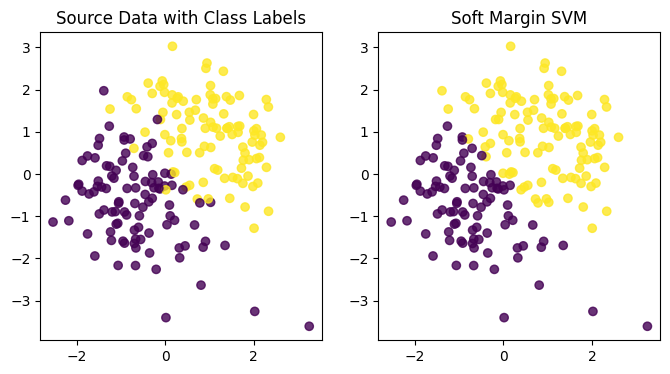

In [520]:
# get alpha
alpha = np.array([x for x in results['x']])

# compute source hyperplane
WS = np.dot(alpha * source_y, source_X)

# plot results
svm_classification = np.sign(source_X @ WS)

# plot source data
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].scatter(source_X[:, 0], source_X[:, 1], c=source_y, alpha=0.8)  # training data with class labels
ax[1].scatter(source_X[:, 0], source_X[:, 1], c=svm_classification, alpha=0.8)   # training data with SVM predicted labels

# titles
ax[0].set_title('Source Data with Class Labels')
ax[1].set_title('Soft Margin SVM')

# print accuracy
print("Soft Margin SVM (C={}) Training Accuracy:".format(C), str(100*(svm_classification == source_y).sum()/len(source_y)) + '%')

plt.show()

The domain adaptation quadratic program is given by:

$$
\argmin_{\alpha} B \sum_{i=1}^n \alpha_i y_i \boldsymbol{w}_S^T \boldsymbol{x}_i \;\; \text{s.t.} \;\; 0 \leq \alpha \leq C, \; \sum_{i=1}^n \alpha_i y_i = 0
$$

In [521]:
def domain_adaptation_SVM(X, y, WS, C, B):
    """
    ;param X: (ndarray) data
    ;param y: (ndarray) target
    ;param WS: (array) coefficients of source hyperplane
    ;param C: (float) SVM hyperparameter
    ;param B: (float) SVM hyperparameter
    """
    # get number of instances
    n = X.shape[0]
    
    P = matrix(np.diag(B * y * (X @ WS)))
    q = matrix(np.zeros(n).astype(float))

    # G and h for inequality constraints
    g1 = np.asarray(np.diag(np.ones(n) * -1))
    g2 = np.asarray(np.diag(np.ones(n)))
    G = matrix(np.append(g1, g2, axis=0))
    G = matrix(G)
    h = matrix(np.append(np.zeros(n), (np.ones(n) * C), axis =0))

    # A and b for equality constraints
    A = matrix(y.astype(float).reshape(1, n))
    b = matrix([0.])

    return solvers.qp(P, q, G, h, A, b)

# solve SVM for source dataset
adaptation_results = domain_adaptation_SVM(target_X, target_y, WS=WS, C=100, B=1)

     pcost       dcost       gap    pres   dres
 0:  1.8852e-03 -5.0000e+03  5e+03  3e-13  1e-13
 1:  1.8852e-03 -5.0009e+01  5e+01  3e-14  2e-15
 2:  1.8844e-03 -5.0942e-01  5e-01  2e-13  2e-17
 3:  1.8138e-03 -1.3587e-02  2e-02  1e-13  7e-19
 4:  7.6410e-04 -1.1989e-03  2e-03  3e-14  6e-20
 5:  2.3336e-04 -4.0033e-04  6e-04  4e-14  2e-20
Terminated (singular KKT matrix).


Domain Adaptation SVM (C=0.1) Training Accuracy: 98.0%


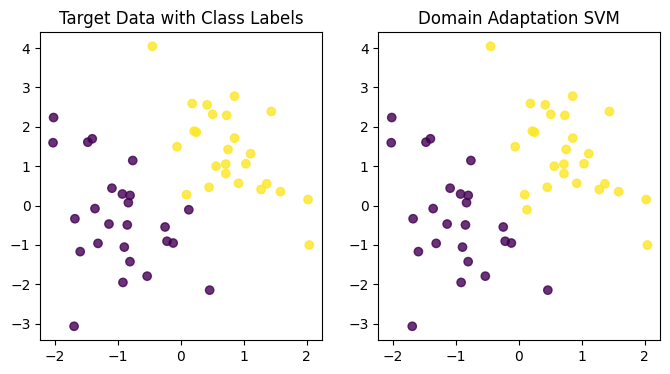

In [522]:
# get alpha
alpha = np.array([x for x in adaptation_results['x']])

# compute source hyperplane
WT = np.dot(alpha * target_y, target_X)

# plot results
svm_classification = np.sign(target_X @ WT)

# plot source data
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].scatter(target_X[:, 0], target_X[:, 1], c=target_y, alpha=0.8)  # training data with class labels
ax[1].scatter(target_X[:, 0], target_X[:, 1], c=svm_classification, alpha=0.8)   # training data with SVM predicted labels

# titles
ax[0].set_title('Target Data with Class Labels')
ax[1].set_title('Domain Adaptation SVM')

# print accuracy
print("Domain Adaptation SVM (C={}) Training Accuracy:".format(C), str(100*(svm_classification == target_y).sum()/len(target_y)) + '%')

plt.show()

## SkLearn's SVM (Code) [20pts]

Use the implementation of SkLearn’s SVM with three different kernel selections. Implement the
SVMs on five binary classification datasets and write a paragraph that describes the kernels you
selected and the results that you observed.

#### Dataset 0 : Sklearn's Breast Cancer
Source: sklearn

Binary target variable: Breast Cancer 

In [2]:
# binary classification of malignant cancer
from sklearn.datasets import load_breast_cancer

# load data
data_0 = load_breast_cancer()
X0 = data_0.data
y0 = data_0.target

#### Dataset 1: Employee Analysis | Attrition Report
Source: https://www.kaggle.com/datasets/whenamancodes/hr-employee-attrition?resource=download

Binary target variable: Attrition

In [3]:
# import data
data_1 = pd.read_csv('data/HR Employee Attrition.csv')

# map Attrition yes:1 and no:-1
data_1['Attrition'] = data_1['Attrition'].map({'Yes':1, 'No':-1})

# drop all non-numerical features
data_1 = data_1.loc[:, data_1.dtypes != 'object']

# separate target from predictors
y1 = data_1.Attrition.copy()
X1 = data_1.drop('Attrition', axis=1).to_numpy()

# show header
data_1.head()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,1102,1,2,1,1,2,94,3,...,1,80,0,8,0,1,6,4,0,5
1,49,-1,279,8,1,1,2,3,61,2,...,4,80,1,10,3,3,10,7,1,7
2,37,1,1373,2,2,1,4,4,92,2,...,2,80,0,7,3,3,0,0,0,0
3,33,-1,1392,3,4,1,5,4,56,3,...,3,80,0,8,3,3,8,7,3,0
4,27,-1,591,2,1,1,7,1,40,3,...,4,80,1,6,3,3,2,2,2,2


#### Dataset 2: Speed Dating
Source: https://www.kaggle.com/datasets/whenamancodes/speed-dating

Binary target variable: Dating Match

In [4]:
# read data
data_2 = pd.read_csv('data/Speed Dating Data.csv', encoding = "ISO-8859-1")

# drop all non-numerical features
data_2 = data_2.loc[:, data_2.dtypes != 'object']

# drop id
data_2.drop(['iid', 'id', 'idg', 'pid'], axis=1, inplace=True)

# separate target from predictors
X2 = data_2.drop('match',axis=1).to_numpy()
y2 = data_2.match.copy()

# view header
data_2.head()

,gender,condtn,wave,round,position,positin1,order,partner,match,int_corr,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,0,1,1,10,7,NaN,4,1,0,0.14,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,0,1,1,10,7,NaN,3,2,0,0.54,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,0,1,1,10,7,NaN,10,3,1,0.16,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,0,1,1,10,7,NaN,5,4,1,0.61,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,0,1,1,10,7,NaN,7,5,1,0.21,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


#### Dataset 3: Alcohol Effects
Source: https://www.kaggle.com/datasets/whenamancodes/alcohol-effects-on-study

Binary target variable: Good health ($\geq$ 3 in health index)

In [5]:
# read data
data_3 = pd.read_csv('data/Alcohol Effects/Maths.csv')

# create target variable
data_3.health = (data_3.health >= 3).astype(int)

# drop all non-numerical features
data_3 = data_3.loc[:, data_3.dtypes != 'object']

# separate target from predictors
X3 = data_3.drop('health',axis=1).to_numpy()
y3 = data_3.health.copy()

data_3.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,18,4,4,2,2,0,4,3,4,1,1,1,6,5,6,6
1,17,1,1,1,2,0,5,3,3,1,1,1,4,5,5,6
2,15,1,1,1,2,3,4,3,2,2,3,1,10,7,8,10
3,15,4,2,1,3,0,3,2,2,1,1,1,2,15,14,15
4,16,3,3,1,2,0,4,3,2,1,2,1,4,6,10,10


#### Dataset 4: Play Store Apps
Source: https://www.kaggle.com/datasets/whenamancodes/play-store-apps

Binary target variable: Positive sentiment

In [6]:
# read data
data_40 = pd.read_csv('data/Google Play Store/googleplaystore.csv')
data_41 = pd.read_csv('data/Google Play Store/googleplaystore_user_reviews.csv')

# merge data
data_4 = data_40.merge(data_41, left_on='App', right_on='App', how='left')

# create target variable
data_4.Sentiment = (data_4.Sentiment == 'Positive').astype(int)

# drop unneeded columns
data_4.drop(['Last Updated', 'Current Ver', 'Android Ver', 'Translated_Review', 'App'], axis=1, inplace=True)

# convert numerical columns to numbers
for col in ['Price', 'Reviews', 'Size']:
    data_4['{}'.format(col)] = data_4['{}'.format(col)].str.extract('(\d+)').astype(float)

# split up genre column
data_4[['Genres','Genre_2']] = data_4['Genres'].str.split(';',expand=True)
data_4.rename(columns={'Genres':'Genre_1'}, inplace=True)

# clean
data_4 = data_4[data_4.Genre_1 != 'February 11, 2018']

# get categorical features and one-hot vectorize
data_4 = pd.concat([
    pd.get_dummies(data_4.loc[:, data_4.dtypes == 'object']),  # one-hot categorical
    data_4.loc[:, data_4.dtypes != 'object']  # numerical
], axis=1)

# separate target from predictors
X4 = data_4.drop('Sentiment',axis=1).to_numpy()
y4 = data_4.Sentiment.copy()

# show header
print(len(data_4))
data_4.head()

131970


,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,Category_COMICS,Category_COMMUNICATION,Category_DATING,Category_EDUCATION,Category_ENTERTAINMENT,...,Genre_2_Education,Genre_2_Music & Video,Genre_2_Pretend Play,Rating,Reviews,Size,Price,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,4.1,159.0,19.0,0.0,0,NaN,NaN
1,1,0,0,0,0,0,0,0,0,0,...,0,0,1,3.9,967.0,14.0,0.0,0,-0.250,1.000000
2,1,0,0,0,0,0,0,0,0,0,...,0,0,1,3.9,967.0,14.0,0.0,0,-0.725,0.833333
3,1,0,0,0,0,0,0,0,0,0,...,0,0,1,3.9,967.0,14.0,0.0,0,0.000,0.000000
4,1,0,0,0,0,0,0,0,0,0,...,0,0,1,3.9,967.0,14.0,0.0,0,NaN,NaN


In [12]:
# import sklearn required modules
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

# list of datasets, kernels for experiment
datasets = [
    ('Cancer', X0, y0), 
    ('Attrition', X1, y1), 
    ('Speed Data', X2, y2),
    ('Health', X3, y3),
    ('Sentiment', X4[:50000, :], y4.iloc[:50000])
]
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

# construct empty array to store results
n = len(datasets) * len(kernels)
exp_results = np.empty((n, 4), dtype='object')  # kernel, dataset, mean accuracy, standard deviation
dataset_names = ['Breast Cancer', 'Employee Attrition', 'Speed Data Match']

# include all CV results
cv = 5  # cross validation splits
n = len(datasets) * len(kernels) * cv
cv_results = np.empty((n, 3), dtype='object')

# run experiment
i = 0
for dataset_name, X, y in datasets:
    for kernel in kernels:
        # split dadta into test, train
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.33, random_state=401)
        # instantiate pipeline
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
            ('selector', VarianceThreshold(threshold=0.5)),
            ('PCA',  PCA(n_components=10)),
            ('model', SVC(C=1, kernel=kernel, random_state=324))
        ])
        # fit data
        pipe.fit(X_train, y_train)
        # run CV 
        scores = cross_val_score(pipe, X_test, y_test, cv=cv, scoring='accuracy')
        # save results and increment
        exp_results[i, :] = np.array([dataset_name, kernel, scores.mean(), scores.std()])
        j = 0
        for score in scores:
            cv_results[i + j, :] = np.array([dataset_name, kernel, score])
            j+= 1
        i += 1

# get results
exp_results = pd.DataFrame(exp_results)
exp_results.columns = ['Dataset', 'Kernel', 'Accuracy', 'STD']
exp_results.head()

/var/folders/7h/tdfv8d5d6d79_0583_jhq_pm0000gn/T/ipykernel_53475/946050102.py:17: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ('Sentiment', X4[:50000, :], y4[:50000])


,Dataset,Kernel,Accuracy,STD
0,Cancer,linear,0.9574679943100994,0.026870852210795746
1,Cancer,poly,0.8724039829302989,0.030955097832565212
2,Cancer,rbf,0.9682788051209104,0.019656938458178917
3,Cancer,sigmoid,0.9735419630156471,0.023539276919985915
4,Attrition,linear,0.8477382705659583,0.004012727389482716


Plot results

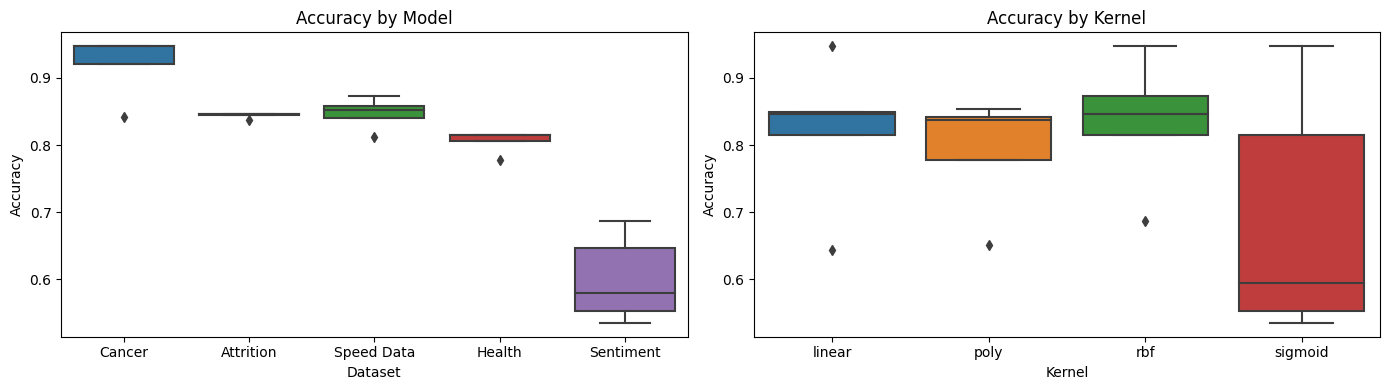

In [11]:
from seaborn import boxplot

cv_results = pd.DataFrame(cv_results)
cv_results.columns = ['Dataset', 'Kernel', 'Accuracy']
cv_results.Accuracy = cv_results.Accuracy.astype(float)

# create figure
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

# accuracy by model
boxplot(data=cv_results, x='Dataset', y='Accuracy', ax=ax[0])
ax[0].set_title('Accuracy by Model')

# accuracy kernel
boxplot(data=cv_results, x='Kernel', y='Accuracy', ax=ax[1])
ax[1].set_title('Accuracy by Kernel')

plt.tight_layout()
plt.show()

The kernels I implemented were the linear, poly rbf and sigmoid kernels. Linear is the dot product $\langle x, x' \rangle$, polynomial is $(\gamma \langle x, x' \rangle + r)^d$, the Radial Basis Function (RBF) inner product is given by $\exp{-\gamma ||x - x'||^2}$ where $\gamma >0$, and sigmoid is $\tanh(\gamma \langle x, x' \rangle + r)$. C is a common hyperparameter to all kernels, $\gamma$ influences how much incluence a single training example has.